# Stanford Cars - EfficientNet-b7 with Mixup and ZeroDropOut

- b7 + Mixup = 94.9
- b7 + Mixup + extra 10 = 95.1
- b7 + RangerQH = ?
- b7 + Mixup RangerQH += ?

## TL;DR
- Achieved **94.79%** 5-run, 40epoch, mean test set accuracy on Stanford Cars using Mish EfficientNet-b3 + Ranger
- Beat the EfficientNet paper EfficientNet-b3 result by **0.2%**
- EfficientNet author's best result using b3 was 93.6%, best EfficientNet result was 94.8% (current SOTA) with EfficientNet-b7
- Used MEfficientNet-b3, created by swapping the Squish activation function for the **Mish** activation function
- Used the **Ranger** optimisation function (a combination of RAdam and Lookahead) and trained with **FlatCosAnnealScheduler**
- EfficientNet-b3 with Ranger but without Mish was giving test set accuracy around 93.4% (-0.4%) and was much more stable to train than my efforts to train the model with RMSProp, which was used in the paper


## Credits: 
- Ranger - @lessw2020
    - Lookahead paper: [Lookahead Optimizer: k steps forward, 1 step back](https://arxiv.org/abs/1907.08610)
    - RAdam paper: [On the Variance of the Adaptive Learning Rate and Beyond, RAdam](https://arxiv.org/abs/1908.03265)
    - @lessw2020 Ranger implementation https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer/blob/master/ranger.py
    - version 9.3.19 used
 
- Mish @digantamisra98
    - Paper: [Mish: A Self Regularized Non-Monotonic Neural Activation Function](https://arxiv.org/abs/1908.08681v1)
    - Mish Repo: https://github.com/digantamisra98/Mish
    - Mish blog: https://medium.com/@lessw/meet-mish-new-state-of-the-art-ai-activation-function-the-successor-to-relu-846a6d93471f
    - Mish code implementation - @lessw2020 - https://github.com/lessw2020/mish/blob/master/mish.py
    
- EfficientNet - @lukemelas
    - Efficient Pytorch implementation that I swapped in Mish for: https://github.com/lukemelas/EfficientNet-PyTorch

- FlatCosAnnealScheduler - @muellerzr
    - Code taken from fastai thread below, being added to the fastai rep atm

- [Inspirational fastai thread, credit to all the contributors here](https://forums.fast.ai/t/meet-mish-new-activation-function-possible-successor-to-relu/53299/280)


### Training Params used:
   - 40 epoch
   - lr = 15e-4
   - start_pct = 0.10
   - wd = 1e-3
   - bn_wd=False
   - true_wd=True

*Default Ranger params were used*: 
   - alpha=0.5
   - k=6
   - N_sma_threshhold=5
   - betas=(.95,0.999)
   - eps=1e-5

### Augmentations used:
- Image size : 299 x 299
- Standard Fastai transforms from **get_transforms()**: 
     - do_flip = True, max_rotate = 10.0, max_zoom = 1.1, max_lighting = 0.2, max_warp = 0.2, p_affine: float = 0.75, p_lighting = 0.75
- **ResizeMethod.SQUISH**, which I found worked quite well from testing with ResNet152

### Training Notes
- Unlike testing done on the fastiai forums with XResNet and the Imagewoof dataset, this setup performed better with a shorter amount of time with a flat lr, followed by a longer cosine anneal.
- I used the full test set as the validation set, similar to the Imagewoof thread in the fastai thread linked above
- I manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs. This persisted even when using learn.purge() and learn.destroy(). There had been a mention on the forums that the lookahead element of the Ranger implementation might have been responsible, but the problem persisted even after using version 9.3.19 which was supposed to address the issue.
- Ran on a Paperspace P4000 machine

### Thanks
Thanks as always to the amazing team at fast.ai and the fastai community! This and the following notebooks are all thanks to fastai's AMAZING MOOC and deep learning library, checkout https://fast.ai for the course and library, you won't regret it!

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from pathlib import Path

from fastai import *
from fastai.vision import *
from fastai.utils.mem import *

# @lukemelas EfficientNet implementation: https://github.com/lukemelas/EfficientNet-PyTorch
#from efficientnet_pytorch import EfficientNet

# Modified version of @lukemelas' EfficientNet implementation with Mish instead of Swish activation
from MEfficientNet_PyTorch.efficientnet_pytorch import EfficientNet as MEfficientNet
#from MEfficientNet_ZeroDropOut_PyTorch.efficientnet_pytorch import EfficientNet as MEfficientNet

# @lessw2020 implementation : https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer/blob/master/ranger.py
# version 9.3.19 used
from ranger import Ranger

# @lessw2020 implementation : https://github.com/lessw2020/RangerQH-Testing
from rangerqh import RangerQH

## Getting the Data

In [2]:
path = 'data/'
labels_df = pd.read_csv('labels_df.csv')
labels_df.head(3)

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,class_name,is_test,filename_cropped,bbox_h,bbox_w
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,0,cropped_00001.jpg,260,531
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,0,cropped_00002.jpg,472,833
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,0,cropped_00003.jpg,273,517


Lets look closer at the data, how many class_ids do we have? Does it match the number of class names?

## Data Loading
Used the standard fastai image transforms and held out 20% of the training data for validation.

In [3]:
def get_data(SZ:int=299):
    SEED = 42
    LABEL = 'class_name'
    
    car_tfms = get_transforms()
    
    # Get test data
    TEST_SZ = 456
    src_test = (ImageList.from_df(labels_df, path, folder='merged', cols='filename')
           # the 'is_test' column has values of 1 for the test set
           .split_from_df(col='is_test')
           .label_from_df(cols=LABEL))

    data_test = (src_test.transform(car_tfms, 
                                  size=TEST_SZ,  
                                  resize_method=ResizeMethod.SQUISH, 
                                  padding_mode='reflection')
                .databunch()
                .normalize(imagenet_stats))
     
    return data_test

data_test = get_data(SZ=456)

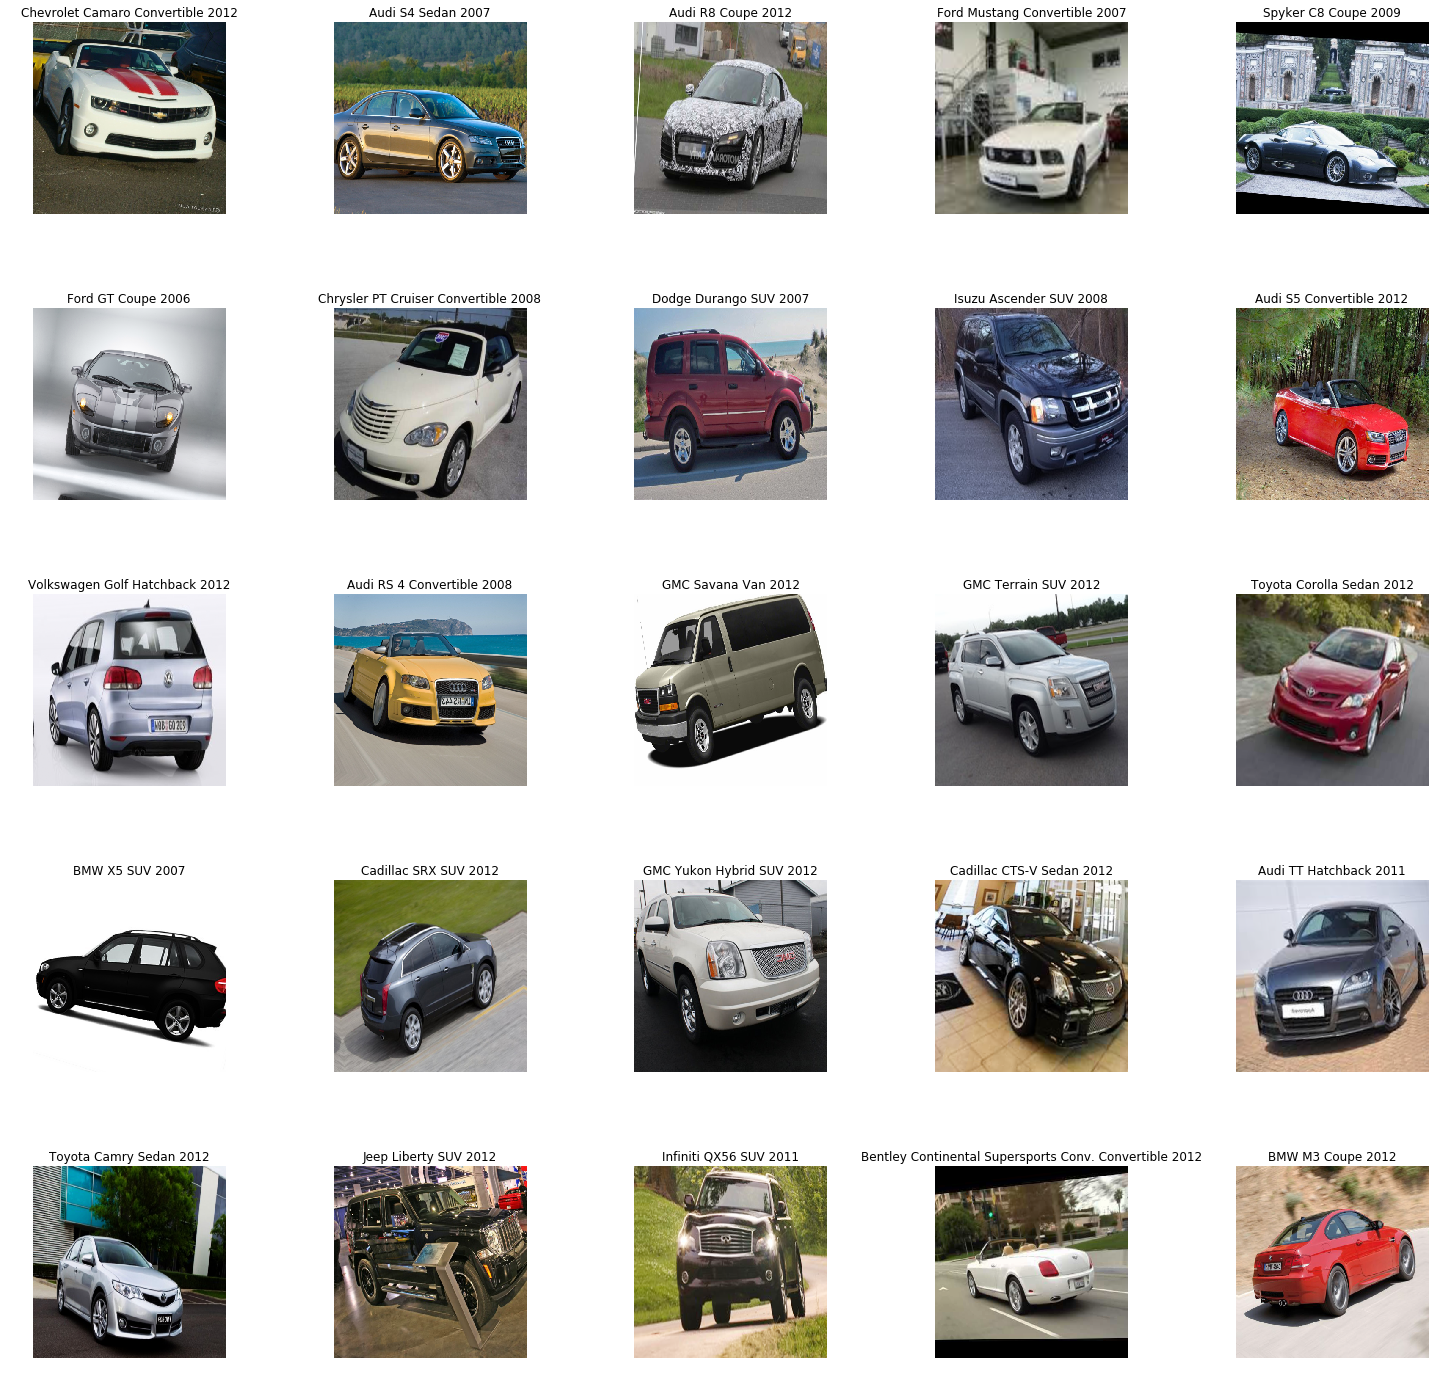

In [4]:
data_test.show_batch()

### Flat and cosine annealer

In [4]:
# By @muellerzr on the fastai forums:
# https://forums.fast.ai/t/meet-mish-new-activation-function-possible-successor-to-relu/53299/133       

from fastai.callbacks import *

def FlatCosAnnealScheduler(learn, lr:float=4e-3, tot_epochs:int=1, moms:Floats=(0.95,0.999),
                          start_pct:float=0.72, curve='cosine'):
    "Manage FCFit trainnig as found in the ImageNette experiments"
    n = len(learn.data.train_dl)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":
        curve_type=annealing_cos
    elif curve=="linear":
        curve_type=annealing_linear
    elif curve=="exponential":
        curve_type=annealing_exp
    else:
        raiseValueError(f"annealing type not supported {curve}")

    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr).schedule_hp('mom', moms[0])
    phase1 = TrainingPhase(batch_finish).schedule_hp('lr', lr, anneal=curve_type).schedule_hp('mom', moms[1])
    phases = [phase0, phase1]
    return GeneralScheduler(learn, phases)
                
def fit_fc(learn:Learner, tot_epochs:int=None, lr:float=defaults.lr,  moms:Tuple[float,float]=(0.95,0.85), start_pct:float=0.72,
                  wd:float=None, callbacks:Optional[CallbackList]=None, show_curve:bool=False)->None:
    "Fit a model with Flat Cosine Annealing"
    max_lr = learn.lr_range(lr)
    callbacks = listify(callbacks)
    callbacks.append(FlatCosAnnealScheduler(learn, lr, moms=moms, start_pct=start_pct, tot_epochs=tot_epochs))
    learn.fit(tot_epochs, max_lr, wd=wd, callbacks=callbacks)

## Save Metrics

In [5]:
def save_metrics_to_csv(exp_name, run_count, learn, metrics):
    for m in metrics:
        name = f'{m}_{exp_name}_run{str(run_count)}_2019-09_23'

        ls = []
        if m == 'val_loss_and_acc':
            acc = []
            for l in learn.recorder.metrics:
                 acc.append(l[0].item())
            ls = learn.recorder.val_losses 

            d = {name: ls, 'acc': acc}
            df = pd.DataFrame(d)
            #df.columns = [name, 'acc']
        elif m == 'trn_loss':
            for l in learn.recorder.losses:
                ls.append(l.item())
            df = pd.DataFrame(ls)
            df.columns = [name]

        df.to_csv(f'{name}_{m}.csv')
        print(df.head())

In [6]:
effnet_b7 = 'efficientnet-b7'
def getMishModel(data, model_name, use_dropout=True):
    model = MEfficientNet.from_pretrained(model_name, data.c, use_dropout)
    return model

## Load b7 with Zero DropOut

In [7]:
mish_model = getMishModel(data_test, effnet_b7, use_dropout=False) 

Loaded pretrained weights for efficientnet-b7


In [8]:
optar=partial(RangerQH,nus=(.70,1.0),betas=(0.92, 0.999),eps=1e-6)

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from ranger import Ranger

data_test.batch_size = 12

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=optar,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy(),
                # callback_fns=BnFreeze
               ).mixup().to_fp16()

fit_fc(learn, tot_epochs=40, lr=15e-4, start_pct=0.1, wd=1e-3, show_curve=False)

epoch,train_loss,valid_loss,accuracy,time
0,3.409577,2.459980,0.542967,20:08
1,2.661819,1.781189,0.756995,20:09
2,2.339475,1.518628,0.840567,20:09
3,2.281068,1.420429,0.873399,20:09
4,2.188730,1.434061,0.872528,20:11
5,2.133885,1.318294,0.902127,20:10
6,2.138611,1.346760,0.890561,20:09
7,2.012463,1.282165,0.906728,20:10
8,1.985550,1.282925,0.908220,20:11
9,1.930865,1.246060,0.919910,20:11


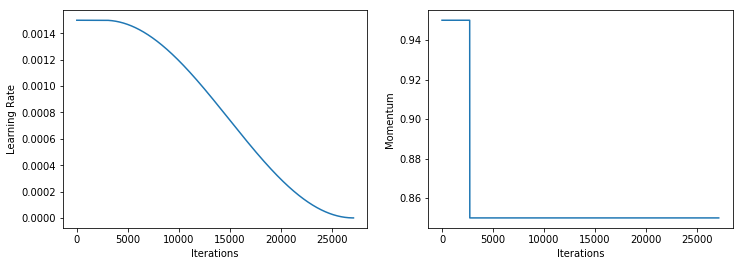

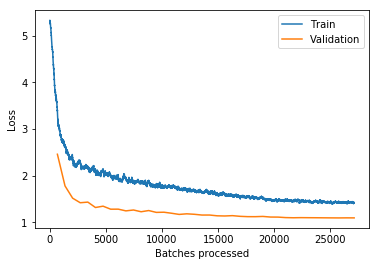

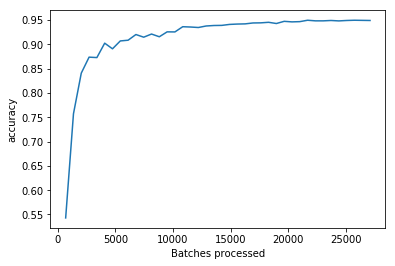

In [10]:
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [11]:
learn.save('b7_zerodropout_1')

In [12]:
exp_name = 'b_7_zerodropout_40e_b7_l5r1e-4_wd1e-3_srt_pct_10'
run_count = 1
metrics = ['trn_loss', 'val_loss_and_acc']
save_metrics_to_csv(exp_name, run_count, learn, metrics)

   trn_loss_b_7_zerodropout_40e_b7_l5r1e-4_wd1e-3_srt_pct_10_run1_2019-09_23
0                                           5.274367                        
1                                           5.303556                        
2                                           5.299532                        
3                                           5.299472                        
4                                           5.290141                        
   val_loss_and_acc_b_7_zerodropout_40e_b7_l5r1e-4_wd1e-3_srt_pct_10_run1_2019-09_23  \
0                                           2.459980                                   
1                                           1.781189                                   
2                                           1.518628                                   
3                                           1.420429                                   
4                                           1.434061                                   

        a

#### Another 10epochs without Mixup

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#del RangerQh
#del optar

#from ranger import Ranger

data_test.batch_size = 12

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=optar,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy(),
                # callback_fns=BnFreeze
               ).to_fp16()

learn.load('b7_zerodropout_1')

fit_fc(learn, tot_epochs=10, lr=1e-5, start_pct=0.1, wd=1e-3, show_curve=False)

epoch,train_loss,valid_loss,accuracy,time
0,0.896659,1.108082,0.950752,20:12
1,0.894480,1.103059,0.951126,20:11
2,0.894242,1.101227,0.950877,20:12
3,0.894934,1.096686,0.950628,20:12
4,0.894131,1.096090,0.950628,20:12
5,0.890874,1.095363,0.950877,20:12
6,0.891311,1.094960,0.951374,20:14
7,0.894681,1.094520,0.951126,20:13
8,0.891226,1.094884,0.950877,20:12
9,0.892326,1.094156,0.950877,20:13


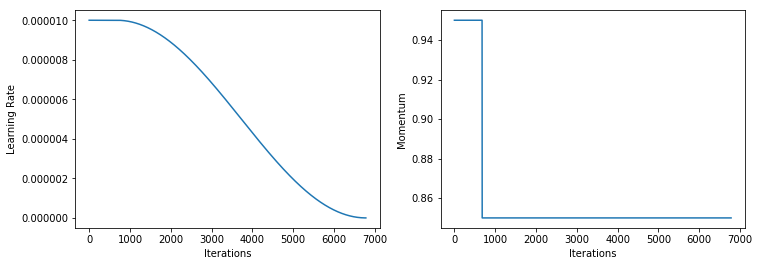

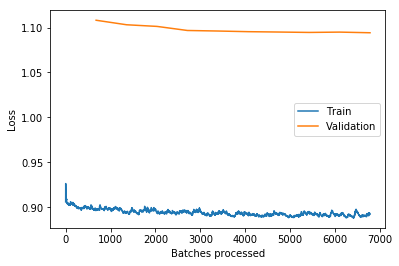

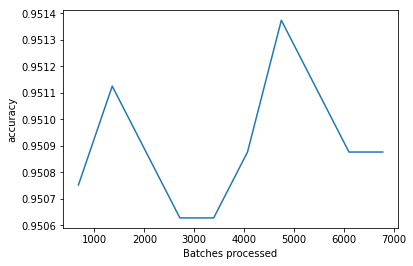

In [14]:
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [15]:
learn.save('b7_zerodropout_1_1')

In [16]:
exp_name = 'b_7_zerodropout_40e_10e_b7_l5r1e-4_wd1e-3_srt_pct_10_1'
run_count = 1
metrics = ['trn_loss', 'val_loss_and_acc']
save_metrics_to_csv(exp_name, run_count, learn, metrics)

   trn_loss_b_7_zerodropout_40e_10e_b7_l5r1e-4_wd1e-3_srt_pct_10_1_run1_2019-09_23
0                                           0.905918                              
1                                           0.926345                              
2                                           0.922427                              
3                                           0.915599                              
4                                           0.915369                              
   val_loss_and_acc_b_7_zerodropout_40e_10e_b7_l5r1e-4_wd1e-3_srt_pct_10_1_run1_2019-09_23  \
0                                           1.108082                                         
1                                           1.103059                                         
2                                           1.101227                                         
3                                           1.096686                                         
4                               

In [17]:
mish_model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

Test with 

from blendaug import *

learn.cutmix()

optar=partial(RangerQH,nus=(.70,1.0),betas=(0.92, 0.999),eps=1e-6)

learn.fit_fc(80, lr=.0042)

Remove dropout, In utils.py: 'efficientnet-b7': (2.0, 3.1, 600, 0.5): https://medium.com/swlh/optimal-cnn-development-use-data-augmentation-not-explicit-regularization-dropout-weight-decay-c46fb6b41c02

Speed up Mish here?: https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/111292#latest-641815

Kaggle - don't do transfer learning? Or transfer learn on retina data?